In [60]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_rxn_svg, draw_pwy_svg
from src.utils import sort_x_by_y, ensure_dirs
from svgutils import compose as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Params
expansion_dir = '../data/processed_expansions/'
fn = "succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk" # Expansion file name
rxns_path = expansion_dir + 'predicted_reactions_' + fn
paths_path = expansion_dir + 'paths_' + fn

In [10]:
# Load reactions and paths
with open(rxns_path, 'rb') as f:
    pred_rxns = pickle.load(f)

with open(paths_path, 'rb') as f:
    paths = pickle.load(f)

In [11]:
# Count how many pathways have full info

n_paths_w_full_info = 0
for p in paths:
    path_full_info = []
    for rh in p.rhashes:
        full_info = False
        for elt in pred_rxns[rh].known_rxns:
            if elt[0] is not None:
                full_info = True
                break

        path_full_info.append(full_info)
    
    if all(path_full_info):
        n_paths_w_full_info += 1

print(n_paths_w_full_info / len(paths), len(paths))


0.5365853658536586 41


In [12]:
# Sort known reactions by average (could alter the sort by value)
for k in pred_rxns.keys():
    pred_rxns[k].sort_known_rxns()

In [13]:
# Set prc mcs attribute for each path by averaging over 
# known reactions
for p in paths:
    p.compute_mean_prc_mcs(pred_rxns)

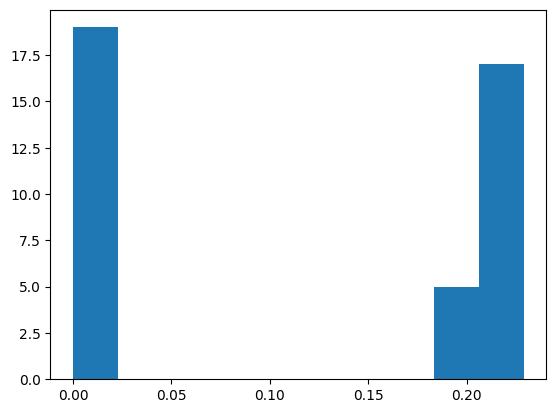

In [14]:
# Sort paths by min reaction prc mcs
min_prc_mcs = []
for p in paths:
    min_prc_mcs.append(p.min_mcs())

min_sorted_idxs = np.arange(len(paths))

min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

plt.hist(min_prc_mcs)
plt.show()

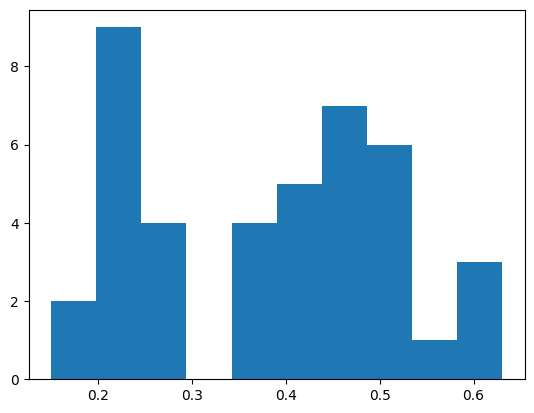

In [15]:
# Sort paths by min reaction prc mcs
mean_prc_mcs = []
for p in paths:
    mean_prc_mcs.append(p.mean_mcs())

mean_sorted_idxs = np.arange(len(paths))

mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(mean_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

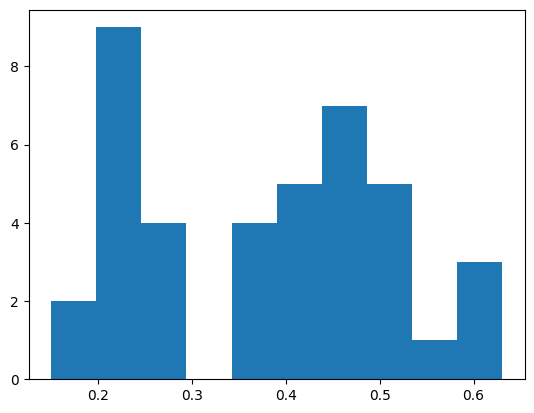

In [16]:
# First sort by min prc_mcs and then by mean prc_mcs

# Get min prc_mcs
min_prc_mcs = []
for p in paths:
    min_prc_mcs.append(p.min_mcs())

# Sort indices by min prc_mcs
min_sorted_idxs = np.arange(len(paths))
min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# Remove zero mins
min_sorted_idxs, min_prc_mcs = np.array(min_sorted_idxs), np.array(min_prc_mcs)
min_sorted_idxs = min_sorted_idxs[min_sorted_idxs > 0]

# Get mean prc_mcs of non-zero min paths
mean_prc_mcs = []
for idx in min_sorted_idxs:
    mean_prc_mcs.append(paths[idx].mean_mcs())

min_mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(min_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

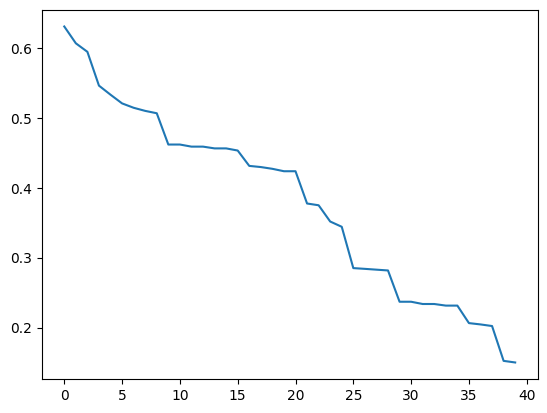

In [17]:
plt.plot(mean_prc_mcs)
plt.show()

In [59]:
n_pwys = 20
pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-3]}/"
ensure_dirs(pwy_svg_outdir)
for i in range(n_pwys):
    pwy_idx = min_mean_sorted_idxs[i]
    sma_hash_pairs = []
    this_rhashes = paths[pwy_idx].rhashes
    for this_rhash in this_rhashes:
        this_rxn = pred_rxns[this_rhash]
        sma_hash_pairs.append([(this_rxn.smarts, this_rhash), (this_rxn.known_rxns[0][1], hash(this_rxn.known_rxns[0][1]))])

    outpath = pwy_svg_outdir + f"{pwy_idx}.svg"
    draw_pwy_svg(sma_hash_pairs, outpath)